In [50]:
import torchaudio
import torch
from dataloader import ESC50
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
from matplotlib import pyplot as plt
import time

In [13]:
BATCH_SIZE = 64

In [6]:
test_esc = ESC50("/home/ifire/learnpytorh/audio/ESC-50/audio")
tensor, label = list(test_esc)[0]

In [9]:
tensor.shape, label

(torch.Size([1, 220500]), 34)

In [10]:
sample_dataloader = torch.utils.data.DataLoader(test_esc, batch_size=64, shuffle=True)

In [14]:
Path.cwd() 

PosixPath('/home/ifire/learnpytorh/audio')

In [15]:
PATH_TO_ESC50 = Path.cwd() / 'ESC-50/audio'
PATH_TO_ESC50

PosixPath('/home/ifire/learnpytorh/audio/ESC-50/audio')

In [17]:
train_es50 = ESC50(PATH_TO_ESC50/ 'train')
valid_es50 = ESC50(PATH_TO_ESC50/ 'valid')
test_es50 = ESC50(PATH_TO_ESC50/ 'test')


In [18]:
train_loader = torch.utils.data.DataLoader(train_es50, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_es50, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_es50, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
## core model 
class AudioNet(nn.Module):
    def __init__(self) -> None:
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(1,128,80,4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128,128,80,3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128,256,80,3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256,512,80,3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgpool = nn.AvgPool1d(30)
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x =  F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgpool(x)
        x = x.permute(0,2,1)
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=2)
    
    
    

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
audio_net = AudioNet()
audio_net.to(device)

AudioNet(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(80,), stride=(3,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(80,), stride=(3,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(80,), stride=(3,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AvgPool1d(kernel_size=(30,), stride

In [26]:
## model hyper parameters

optimizer = optim.Adam(audio_net.parameters(), lr = 1e-5)
loss_fn = nn.CrossEntropyLoss()

In [32]:
for epoch in range(10):
    audio_net.to(device)
    audio_net.train()
    for out in enumerate(train_loader):
        print(len(out[1]))
        input, label = input.to(device), label.to(device)
        optimizer.zero_grad()
        output = audio_net(input)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        

2


AttributeError: 'int' object has no attribute 'to'

In [34]:
import librosa

In [39]:
sample_data, sr = librosa.load("/home/ifire/learnpytorh/audio/ESC-50/audio/train/1-100032-A-0.wav",sr=None)
spectrogram = librosa.feature.melspectrogram(y=sample_data, sr=sr)

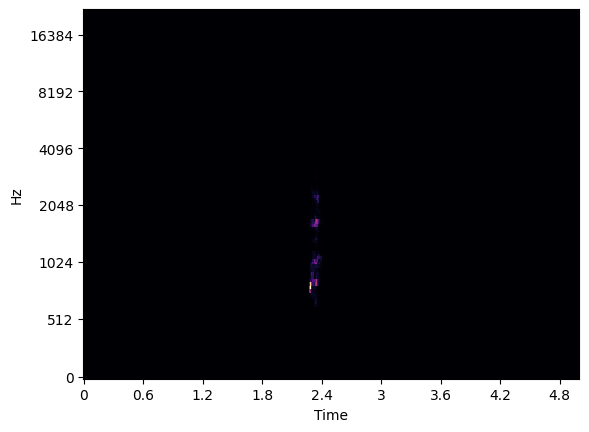

In [40]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

In [42]:
lof_spectogram = librosa.power_to_db(spectrogram, ref=np.max)

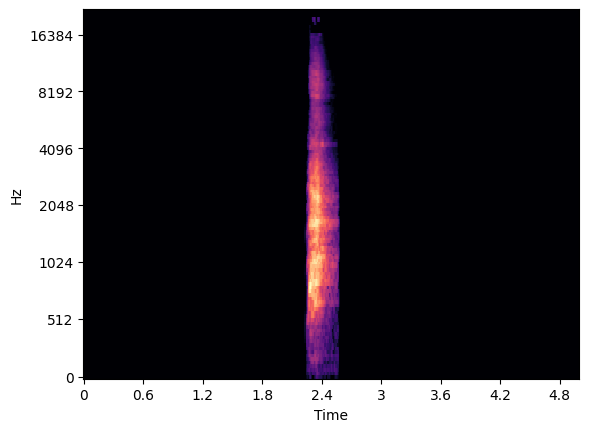

In [43]:
librosa.display.specshow(lof_spectogram, sr=sr, x_axis='time', y_axis='mel')

because these spectograms are image data then it contains the structure of the audio data
therefore we can use the spectgrams along with CCN2d to capture the sturcture and classify them

In [58]:
## new data set with spectograms
class ESC50Spectograms(Dataset):
    def __init__(self, path) -> None:
        files = Path(path).glob('*.wav')
        self.items = [(f, int(f.name.split("-")[-1].replace(".wav", ""))) for f in files]
        self.length = len(self.items)
        self.tranforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        
    def __getitem__(self, index) -> torch.Tensor:
        filename, label = self.items[index]
        audio_tensor, sample_rate = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=audio_tensor, sr= sample_rate)
        lof_spectogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(lof_spectogram, sr=sample_rate, x_axis='time', y_axis='mel')
        
        plt.gcf().canvas.draw()
        audio_data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        audio_data = audio_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return (self.transforms(audio_data), label)
    
    def __len__(self):
        return self.length
                

In [59]:
oldESC50  = ESC50(PATH_TO_ESC50/ 'train')
start_time = time.process_time()
oldESC50.__getitem__(33)
end_time = time.process_time()
old_time = end_time - start_time

NameError: name 'fig' is not defined

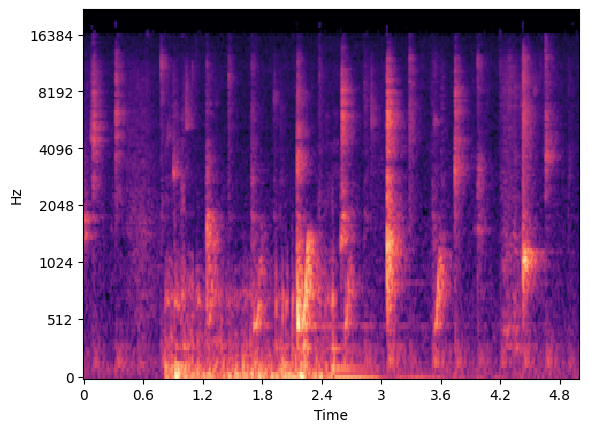

In [60]:
newESC50 = ESC50Spectograms(PATH_TO_ESC50/ 'train')
start_time = time.process_time()
newESC50.__getitem__(33)
end_time = time.process_time()
new_time = end_time - start_time

In [65]:
from torch.utils.tensorboard import SummaryWriter

In [67]:
writer = SummaryWriter()
writer.add_scalar('example', 3)

In [68]:
## testing with random values
for i in range(100):
    writer.add_scalar('Loss', np.random.random(), i)
    writer.add_scalar('Accuracy', np.random.random(), i)

In [69]:
## model representation 
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

In [70]:
writer = SummaryWriter()
model = models.resnet18(False)
writer.add_graph(model, torch.rand(1,3,224,224))


/home/ifire/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ifire/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [71]:
def train(model,
          optimizer,
          loss_fn,
          train_loader,
          test_loader,
          epochs=50):
    model = model.train()
    iteration = 0
    
    for epoch in range(epochs):
        model.train()
        for batch_idx, input, label in train_loader:
            optimizer.zero_grad()
            input, target = input.to(device), label.to(device)
            output = model(input)
            loss = loss_fn(output, label)
            
            writer.add_scalar('loss', loss, epoch)
            loss.backward()
            optimizer.step()
            
        model.eval()
        num_corrects = 0
        num_example = 0
        for batch in valid_loader:
            input, label = batch
            output = model(input)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], target).view(-1)
            
            num_corrects += torch.sum(correct).item()
            num_example += correct.shape[0]
            
            print('[INFO] Epoch - {epoch} : accuracy - {num_corrects/num_example}')
        iteration +=1